In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

# Fixing all random seeds
SEED = 2025
np.random.seed(SEED)
random.seed(SEED)


nb_classes = 2
labels = ["Pas de Récidive", "Récidive"]
ticksx = np.arange(nb_classes) + 0.5
ticksy = np.arange(nb_classes) + 0.5

## utils 

In [2]:
def compute_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")  # Use "weighted" for multiclass
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    return accuracy, balanced_accuracy, f1, precision, recall


def getWrongPatients(yhat, ytrue, patients):
    if len(np.where(yhat != ytrue)) != 0:
        return patients[np.where(yhat != ytrue)]
    else:
        print("No Misclassified Patients.")
        return np.array([0])

## codes

In [3]:
patients_KB_to_eliminate = [23, 31, 54, 60, 68, 72, 76, 84, 86]
patients_R1_to_eliminate = [116, 117, 125, 134, 156, 180, 197, 198]
patients_NaN_to_eliminate = [
    18,
    70,
    114,
    116,
    119,
    212,
]  # 113, 124, 129, 138, 139, 143, 145, 155, 159]

patients_to_eliminate = [208, 231, 250] + list(
    set(patients_KB_to_eliminate + patients_R1_to_eliminate + patients_NaN_to_eliminate)
)
print(len(patients_to_eliminate), sorted(patients_to_eliminate))

df = pd.read_excel("../data/tabs/input_dataframe_prognosis.xlsx")
df = (
    df.loc[~df["patient"].isin(patients_to_eliminate)]
    .sort_values(by="patient")
    .drop("Nbre de lames", axis=1)
)

25 [18, 23, 31, 54, 60, 68, 70, 72, 76, 84, 86, 114, 116, 117, 119, 125, 134, 156, 180, 197, 198, 208, 212, 231, 250]


In [4]:
df_kb = df.loc[
    df["patient"].between(1, 110)
    | df["patient"].between(213, 222)
    | df["patient"].between(253, 260)
]
df_hm = df.loc[df["patient"].between(111, 160)]
df_bj = df.loc[df["patient"].between(161, 212) | df["patient"].between(223, 252)]

df_kb.shape, df_hm.shape, df_bj.shape

((111, 20), (43, 20), (67, 20))

In [5]:
df_kb["Récidive Globale"].value_counts()

Récidive Globale
1    57
0    54
Name: count, dtype: int64

In [6]:
df_hm["Récidive Globale"].value_counts()

Récidive Globale
1    23
0    20
Name: count, dtype: int64

In [7]:
df_bj["Récidive Globale"].value_counts()

Récidive Globale
0    41
1    26
Name: count, dtype: int64

In [8]:
cols_to_scale = [
    "Pattern expansif multinodulaire",
    "log1p_taille",
    "log1p_AFP",
    "%P",
    "%P_max",
    "NP_CntArea_norm",
    "P_CntArea_norm",
    "P_CntArea_norm_max",
    "INTRA-INFLAMS",
    "PERI-INFLAMS",
    "density",
    "mean nucleus area",
    "anisocaryose",
    "nucleocyto index",
]

In [9]:
train = df_kb.loc[df_kb["patient"].between(1, 89)]
test = df_kb.loc[~df_kb["patient"].between(1, 89)]

robust_scaler = RobustScaler()
data_scaled = robust_scaler.fit_transform(train[cols_to_scale])
# Kremlin Bicetre
train[cols_to_scale] = data_scaled
data_scaled = robust_scaler.transform(test[cols_to_scale])
test[cols_to_scale] = data_scaled

# HenriMondor
data_scaled = robust_scaler.transform(df_hm[cols_to_scale])
df_hm[cols_to_scale] = data_scaled

# Beaujon
data_scaled = robust_scaler.transform(df_bj[cols_to_scale])
df_bj[cols_to_scale] = data_scaled

FINAL_COLS = cols_to_scale
X_train = train[FINAL_COLS]
y_train = train["Récidive Globale"]

X_test = test[FINAL_COLS]
y_test = test["Récidive Globale"]
patients_train = train["patient"]
patients_test = test["patient"]

X_hm = df_hm[FINAL_COLS]
y_hm = df_hm["Récidive Globale"]
patients_hm = df_hm["patient"]

X_bj = df_bj[FINAL_COLS]
y_bj = df_bj["Récidive Globale"]
patients_bj = df_bj["patient"]

In [10]:
models = {
    "SVM (kernel=rbf)": SVC(
        kernel="rbf", random_state=SEED, probability=True, C=1.5, gamma="scale"
    ),
}

In [11]:
results = pd.DataFrame(
    columns=[
        "Model",
        "Accuracy",
        "Balanced Accuracy",
        "F1-Score",
        "Precision",
        "Recall",
    ]
)
results_hm = pd.DataFrame(columns=results.columns)
results_bj = pd.DataFrame(columns=results.columns)
results["Model"] = list(models.keys())
results_hm["Model"] = list(models.keys())
results_bj["Model"] = list(models.keys())

cm_results_hm = {}
cm_results_bj = {}
cm_results = {}
dict_models = {}
for name, model in models.items():
    print(f"Training {name}...", end="")
    model.fit(X_train, y_train)  # Train the model

    y_pred = model.predict(X_test)  # Predict on KB
    accuracy, balanced_accuracy, f1, precision, recall = compute_metrics(y_test, y_pred)
    model_results = pd.DataFrame(
        {
            "Model": [name],
            "Accuracy": [accuracy],
            "Balanced Accuracy": [balanced_accuracy],
            "F1-Score": [f1],
            "Precision": [precision],
            "Recall": [recall],
        }
    )
    model_results = model_results.dropna(axis=1, how="all")
    results.loc[results["Model"] == name] = [
        name,
        accuracy,
        balanced_accuracy,
        f1,
        precision,
        recall,
    ]
    cm_results[name] = confusion_matrix(y_test, y_pred)

    y_pred_hm = model.predict(X_hm)  # Predict on HM
    accuracy, balanced_accuracy, f1, precision, recall = compute_metrics(
        y_hm, y_pred_hm
    )
    results_hm.loc[results_hm["Model"] == name] = [
        name,
        accuracy,
        balanced_accuracy,
        f1,
        precision,
        recall,
    ]
    cm_results_hm[name] = confusion_matrix(y_hm, y_pred_hm)

    y_pred_bj = model.predict(X_bj)  # Predict on BJ
    accuracy, balanced_accuracy, f1, precision, recall = compute_metrics(
        y_bj, y_pred_bj
    )
    results_bj.loc[results_bj["Model"] == name] = [
        name,
        accuracy,
        balanced_accuracy,
        f1,
        precision,
        recall,
    ]
    cm_results_bj[name] = confusion_matrix(y_bj, y_pred_bj)
    print(" Done!")

    y_proba = model.predict_proba(X_test)[:, 1]
    y_proba_hm = model.predict_proba(X_hm)[:, 1]
    y_proba_bj = model.predict_proba(X_bj)[:, 1]
    dict_models[name] = [
        model,
        y_pred,
        y_pred_hm,
        y_pred_bj,
        y_proba,
        y_proba_hm,
        y_proba_bj,
    ]

    y_proba = model.predict_proba(X_test)[:, 1]
    y_proba_hm = model.predict_proba(X_hm)[:, 1]
    y_proba_bj = model.predict_proba(X_bj)[:, 1]
    dict_models[name] = [
        model,
        y_pred,
        y_pred_hm,
        y_pred_bj,
        y_proba,
        y_proba_hm,
        y_proba_bj,
    ]

Training SVM (kernel=rbf)... Done!


In [12]:
results = results.sort_values(by="Accuracy", ascending=False)
results["hopital"] = "PB"

results_hm = results_hm.sort_values(by="Accuracy", ascending=False)
results_hm["hopital"] = "HM"

results_bj = results_bj.sort_values(by="Accuracy", ascending=False)
results_bj["hopital"] = "BJ"

ALL_res = pd.concat([results, results_hm])
ALL_res = pd.concat([ALL_res, results_bj])
ALL_res

,Model,Accuracy,Balanced Accuracy,F1-Score,Precision,Recall,hopital
0,SVM (kernel=rbf),0.921053,0.919444,0.920888,0.922011,0.921053,PB
0,SVM (kernel=rbf),0.906977,0.903261,0.906467,0.909974,0.906977,HM
0,SVM (kernel=rbf),0.910448,0.905722,0.910448,0.910448,0.910448,BJ


In [13]:
print("misclassified patients:")
for m in results["Model"]:
    wrong_patients = getWrongPatients(
        dict_models[m][1], y_test.squeeze(), np.array(patients_test)
    )
    liste = list(set(wrong_patients))
    liste.sort()
    print("   {:10s} on PB:".format(m), liste)

for m in results_hm["Model"]:
    wrong_patients = getWrongPatients(
        dict_models[m][2], y_hm.squeeze(), np.array(patients_hm)
    )
    liste = list(set(wrong_patients))
    liste.sort()
    print("   {:10s} on HM:".format(m), liste)

for m in results_bj["Model"]:
    wrong_patients = getWrongPatients(
        dict_models[m][3], y_bj.squeeze(), np.array(patients_bj)
    )
    liste = list(set(wrong_patients))
    liste.sort()
    print("   {:10s} on BJ:".format(m), liste)

misclassified patients:
   SVM (kernel=rbf) on PB: [217, 222, 257]
   SVM (kernel=rbf) on HM: [113, 131, 132, 138]
   SVM (kernel=rbf) on BJ: [162, 168, 181, 185, 244, 248]


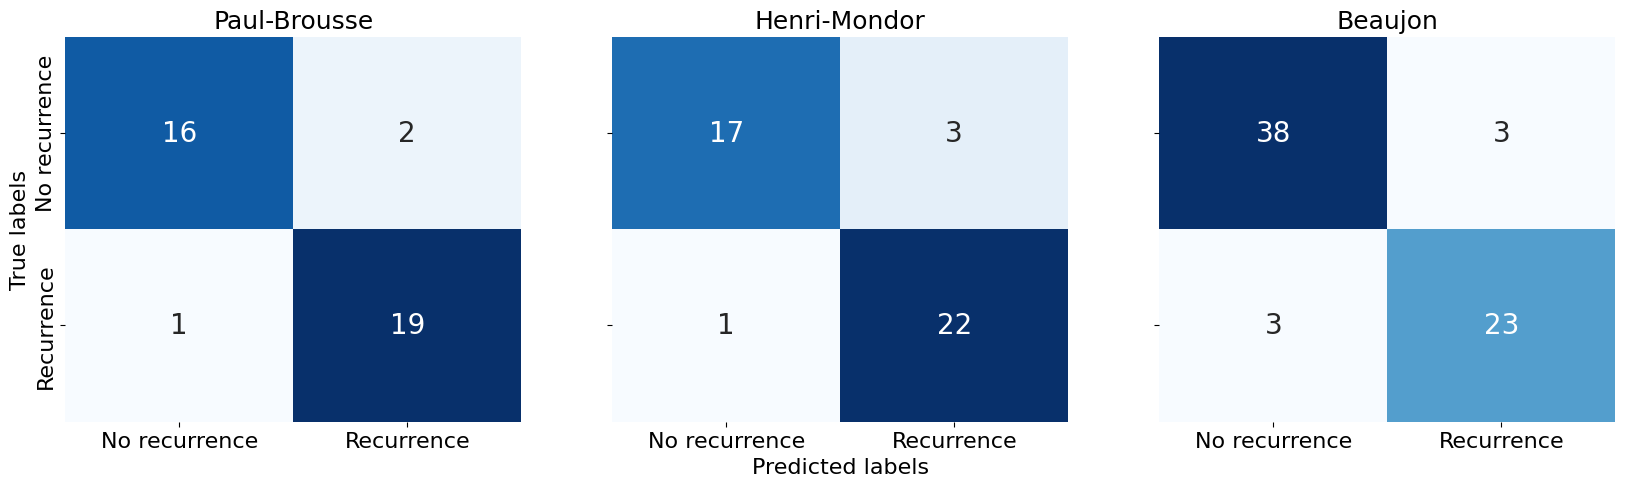

In [14]:
cm1 = cm_results["SVM (kernel=rbf)"]
cm2 = cm_results_hm["SVM (kernel=rbf)"]
cm3 = cm_results_bj["SVM (kernel=rbf)"]

cm_results = {"Paul-Brousse": cm1, "Henri-Mondor": cm2, "Beaujon": cm3}
labels = ["No recurrence", "Recurrence"]
rows, cols = 1, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()
for idx, (model_name, cm) in enumerate(cm_results.items()):
    if idx >= rows * cols:
        break  # Stop if there are more models than grid cells

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[idx],
        cbar=False,
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": 20},
    )
    axes[idx].set_title(f"{model_name}", fontsize=18)
    axes[1].set_xlabel("Predicted labels", fontsize=16)
    axes[0].set_ylabel("True labels", fontsize=16)
    axes[idx].tick_params(axis="x", labelsize=16)
    axes[idx].tick_params(axis="y", labelsize=16)
for i in range(len(cm_results), rows * cols):
    fig.delaxes(axes[i])
plt.show()

### Calibration analysis

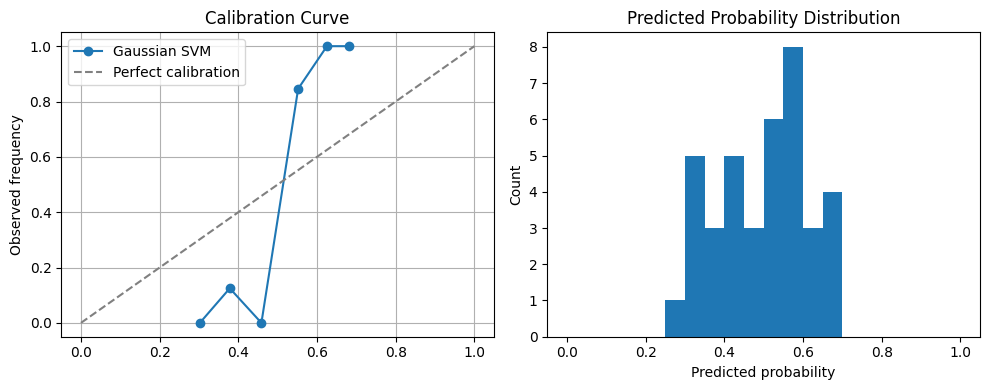

In [15]:
from sklearn.calibration import calibration_curve

svm_model = models["SVM (kernel=rbf)"]
y_proba = svm_model.predict_proba(X_test)[:, 1]
y_pred = svm_model.predict(X_test)

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_proba, n_bins=len(y_proba) // 3, strategy="uniform"
)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharex=True)
ax[0].plot(mean_predicted_value, fraction_of_positives, "o-", label="Gaussian SVM")
ax[0].plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")
ax[0].set_ylabel("Observed frequency")
ax[0].set_title("Calibration Curve")
ax[0].legend()
ax[0].grid(True)

ax[1].hist(y_proba, bins=20, range=(0, 1))
ax[1].set_xlabel("Predicted probability")
ax[1].set_ylabel("Count")
ax[1].set_title("Predicted Probability Distribution")
plt.tight_layout()
plt.show()